In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from scipy.integrate import quad
from scipy.optimize import curve_fit

%matplotlib notebook

# Set up functions

In [2]:
#q   = 1.602e-19# C
#Ib  = 1E-3   # A Beam current
#Eb  = 2      # meV Beam energy
#eta = 1      # adsorbed fraction
#Ei  = 10   # e-h formation energy
#
#G0 = eta/Ei

## Collection efficiency 

All this is based on this paper `E B Yakimov et al 2020 J. Phys. D: Appl. Phys. 53 495108`

In [3]:
def Ic(Eb, tm, W, L, G0):
    """
    Returns Electron Beam Collection Efficiency 
    (EBIC) value as a function of electron beam energy
    for given parameters
    
    Parameters
    ----------
    Eb : float, array 
        Electron beam energy in meV
    tm : float
        Metal thickness in nm
    W : float
        Screen charge region thickness in nm
    L : float 
        Diffusion length in nm
    G0 : float 
        η/Ei portion of absorbed electrons (η)
        with e-h pair formation energy (Ei)
    
    Returns
    -------
    I : float, array
        Electron Beam Collection Efficiency in meV-1 
    """

    q  = 1.602e-19 # C
    Ib = 1e-3 # A
    n  = 1 # arb. units
    
    
    def A(z, Eb):
        R = 7.34*Eb**(1.75)#nm, Eb in keV
        return np.piecewise(z, 
                            [     z < 0.22*R,    z >= 0.22*R],
                            [lambda z: 12.84, lambda z: 3.97])

    def h(z, Eb):
        R = 7.34*Eb**(1.75)#nm, Eb in keV
        return 1.603/R*np.exp(-A(z, Eb)*(z/R - 0.22)**2)
    
    def hexp(z, Eb):
        R = 7.34*Eb**(1.75)#nm, Eb in keV
        return 1.603/R*np.exp(-A(z, Eb)*(z/R - 0.22)**2)*np.exp(-(z-W)/L)

    
    I1 = np.asarray([quad(   h, tm,      W, args=(_Eb), epsrel = 1e-2)[0] for _Eb in Eb])
    I2 = np.asarray([quad(hexp, tm, np.inf, args=(_Eb), epsrel = 1e-2)[0] for _Eb in Eb])
    I  = (I1 + I2)
    I = I*G0
    return I

## Fit data

In [4]:
def fit_data(path, tm, W, time = True):
    """
    Computes optimal parameters for EBIC data 
    and returns fitted data
    
    
    Parameters
    ----------
    path : string
        Path to data file
    tm : float
      Initial guess value of metal thickness
    W : float
        Initial guess value of SCR
    
    Returns
    -------
    E : array
        Electron beam energies from data file in meV
    I : array
        Collection efficiencies for E from data file in meV-1
    Ic : array
        Fitted collection efficiencies for E and popt
    popt : [tm, W, L, G0]
        Optimal fitting parameters for Ic() func
        
    Other Parameters
    ----------------
    time : bollean
        True for Elapsed time display
    """
    
    if time:
        import time 
        start = time.time()
    
    csv = np.loadtxt(path, delimiter = ',')
    
    E = csv[:,0]
    Imax = max(csv[:,1])
    I = csv[:,1]#/Imax ## normalized
    
    X = 7.34*E**(1.75) ##nm, E in keV
    
    guess = [tm, W, 51, 1.]
    bounds = ([1.0, 100.0, 5.0, 1e-4], [250.0, 5.0E4, 850, 10.])
    
    popt, pcov = curve_fit(Ic, E, I, p0 = guess, bounds = bounds) 
    err = np.sqrt(np.diag(pcov))
    #print('optimal = ', popt)
    #print('err = ', err)
    print('Metal thickness : %.2f nm\n'%(popt[0]),
          'SCR width : %.2f nm\n'%(popt[1]),
          'Diffusion length : %.2f ± %.2f nm\n'%(popt[2], err[2]),
          'η/Ei :%.2f ± %.2f eV-1'%(popt[3], err[3]))

    if time:
        print('-----------------------------------------')
        end = time.time()
        print('Elapsed time: %.2f s'%(end - start))
        
    return E, I, Ic(E, *popt), popt

# Plot data
### S1 data fitting

In [5]:
data = []
path = 'data/S1.csv'
E, I_data, I_fit, params = fit_data(path = path, tm = 40, W = 600)
data.append([E, I_data, I_fit, params, path])

Metal thickness : 42.66 nm
 SCR width : 591.29 nm
 Diffusion length : 147.01 ± 68.25 nm
 η/Ei :0.98 ± 8.68 eV-1
-----------------------------------------
Elapsed time: 19.25 s


<IPython.core.display.Javascript object>


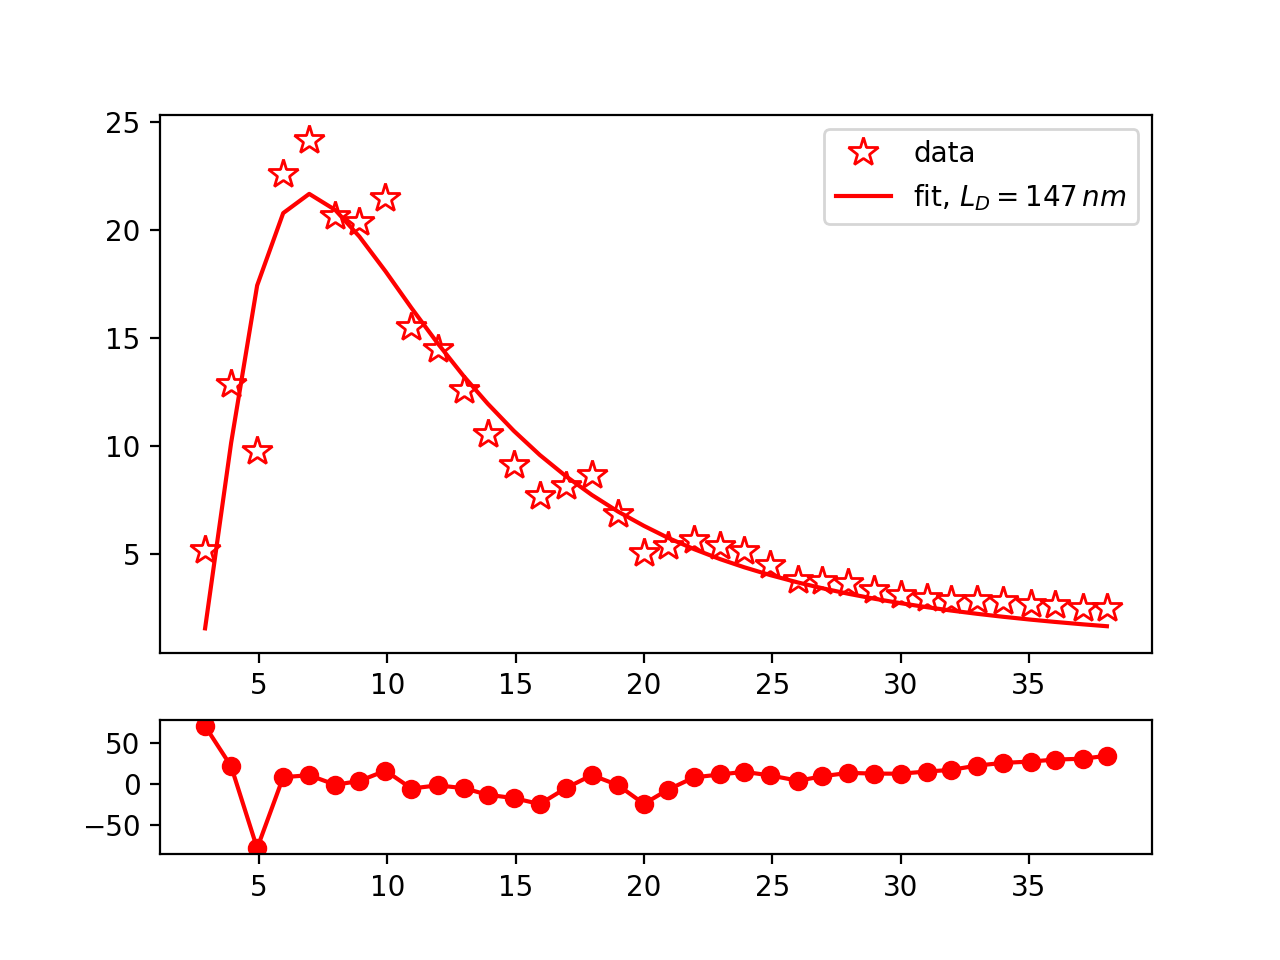

In [6]:
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4,1]})
gs = axs[0].get_gridspec()
#grid = gs.GridSpec(2,1 , height_ratios=[2,1])

axs[0].plot(E, I_data, 'r*', label = r'data', ms = 11, mfc='none')
axs[0].plot(E, I_fit,  'r-', label = r'fit, $L_D = %.0f \,nm$'%params[2])
axs[0].legend()

axs[1].plot(E, (I_data - I_fit)/I_data*100, '-ro',label = 'Error %')

### S3 data fitting

In [7]:
path = 'data/S3.csv'
E, I_data, I_fit, params = fit_data(path = path, tm = 80, W = 500)
data.append([E, I_data, I_fit, params, path])

Metal thickness : 165.54 nm
 SCR width : 1800.46 nm
 Diffusion length : 556.86 ± 0.00 nm
 η/Ei :0.82 ± 0.74 eV-1
-----------------------------------------
Elapsed time: 13.33 s


<IPython.core.display.Javascript object>


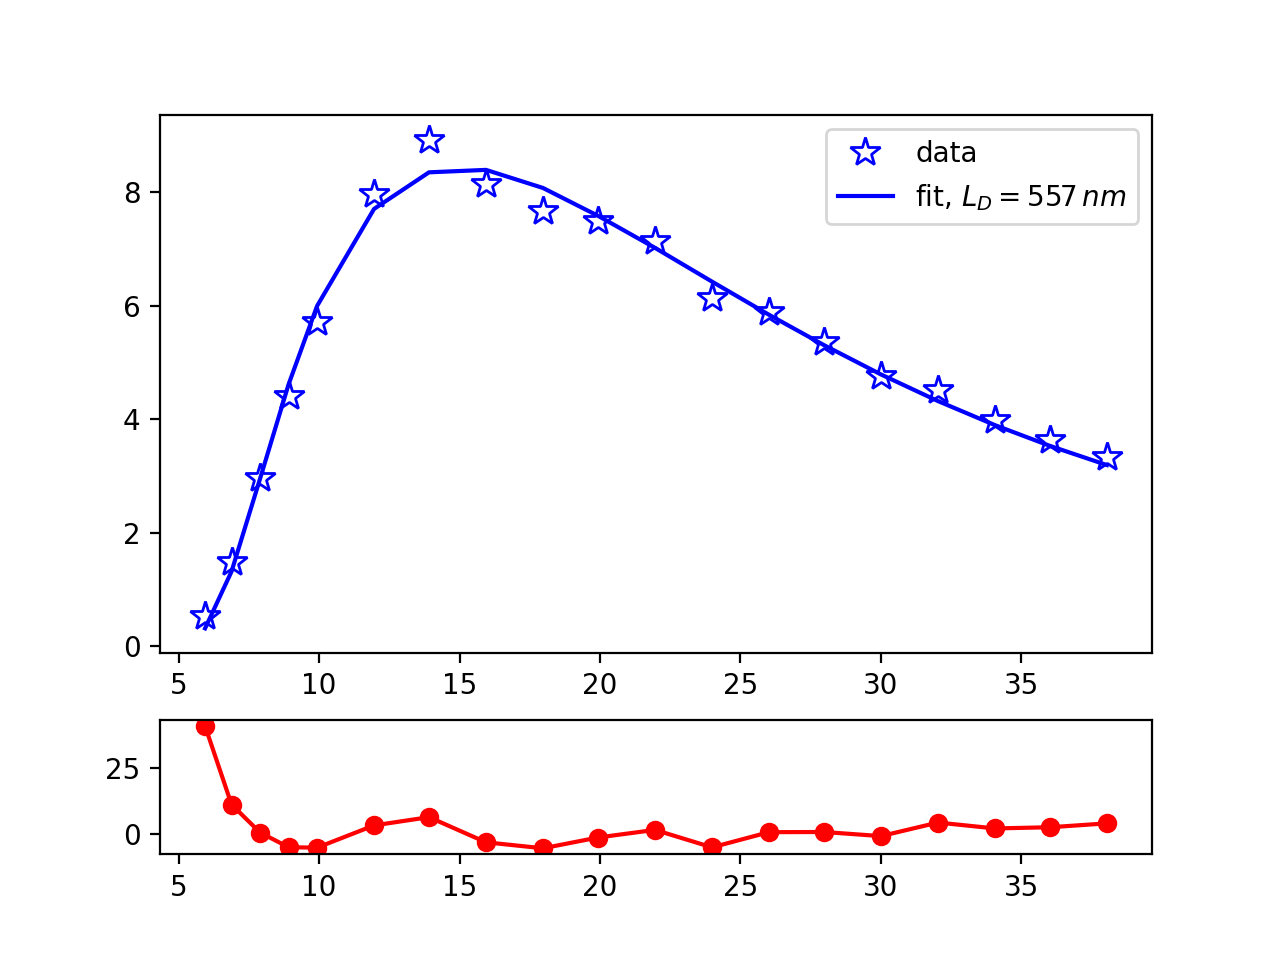

In [8]:
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4,1]})
gs = axs[0].get_gridspec()
#grid = gs.GridSpec(2,1 , height_ratios=[2,1])

axs[0].plot(E, I_data, 'b*', label = r'data', ms = 11, mfc='none')
axs[0].plot(E, I_fit,  'b-', label = r'fit, $L_D = %.0f \,nm$'%params[2])
axs[0].legend()

axs[1].plot(E, (I_data - I_fit)/I_data*100, '-ro',label = 'Error %')

### S2 data fitting

In [9]:
path = 'data/S2.csv'
E, I_data, I_fit, params = fit_data(path = path, tm = 40, W = 500)
data.append([E, I_data, I_fit, params, path])

Metal thickness : 28.79 nm
 SCR width : 378.59 nm
 Diffusion length : 105.65 ± 10.36 nm
 η/Ei :0.88 ± 1.52 eV-1
-----------------------------------------
Elapsed time: 11.02 s


<IPython.core.display.Javascript object>


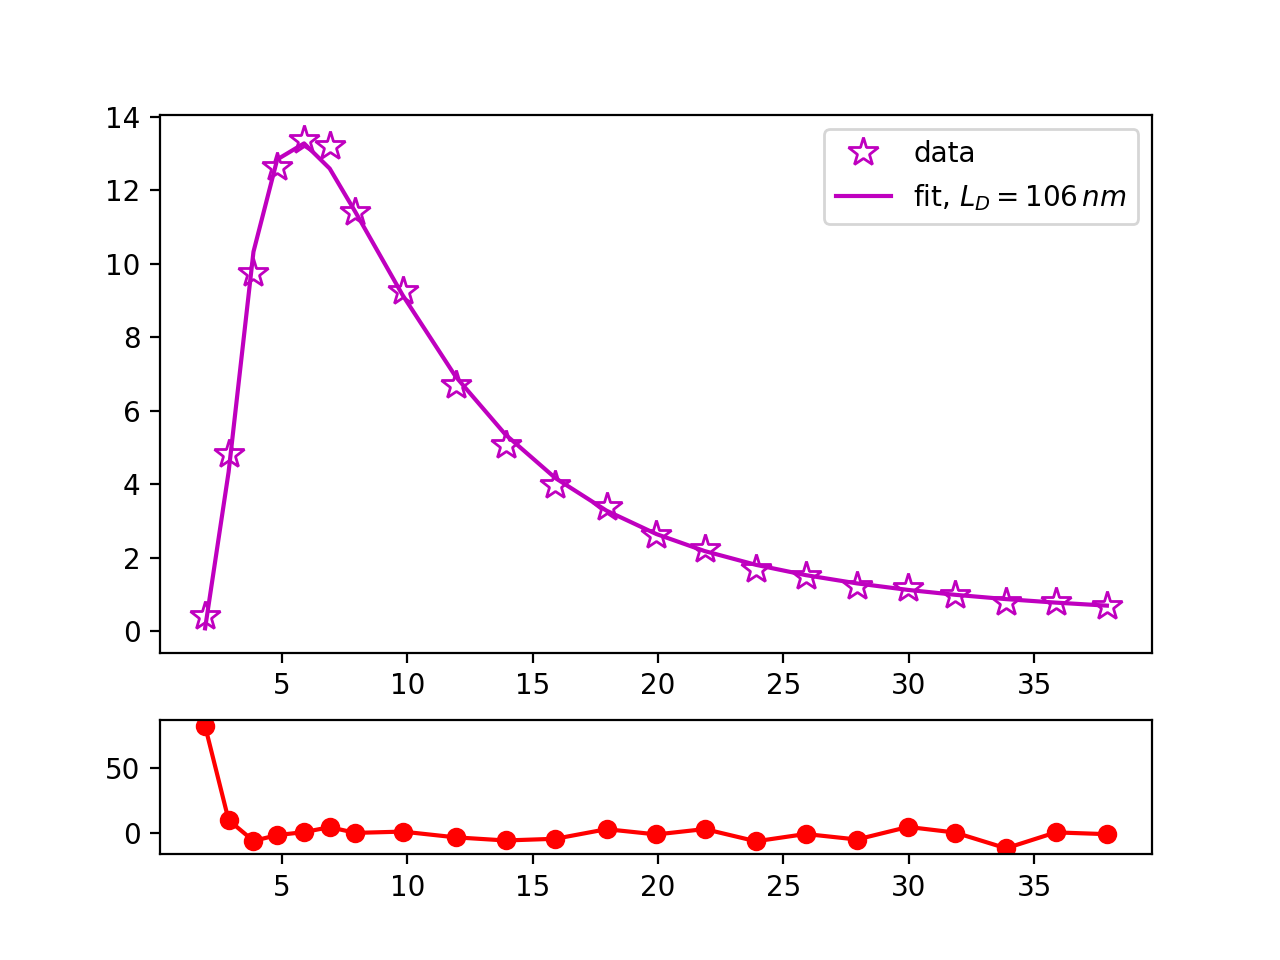

In [10]:
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4,1]})
gs = axs[0].get_gridspec()
#grid = gs.GridSpec(2,1 , height_ratios=[2,1])

axs[0].plot(E, I_data, 'm*', label = r'data', ms = 11, mfc='none')
axs[0].plot(E, I_fit,  'm-', label = r'fit, $L_D = %.0f \,nm$'%params[2])
axs[0].legend()

axs[1].plot(E, (I_data - I_fit)/I_data*100, '-ro',label = 'Error %')

### S4 data Fitting

In [11]:
path = 'data/S4.csv'
E, I_data, I_fit, params = fit_data(path = path, tm = 40, W = 500)
data.append([E, I_data, I_fit, params, path])

Metal thickness : 12.33 nm
 SCR width : 1257.11 nm
 Diffusion length : 489.67 ± 0.00 nm
 η/Ei :0.50 ± 1.16 eV-1
-----------------------------------------
Elapsed time: 20.96 s


<IPython.core.display.Javascript object>


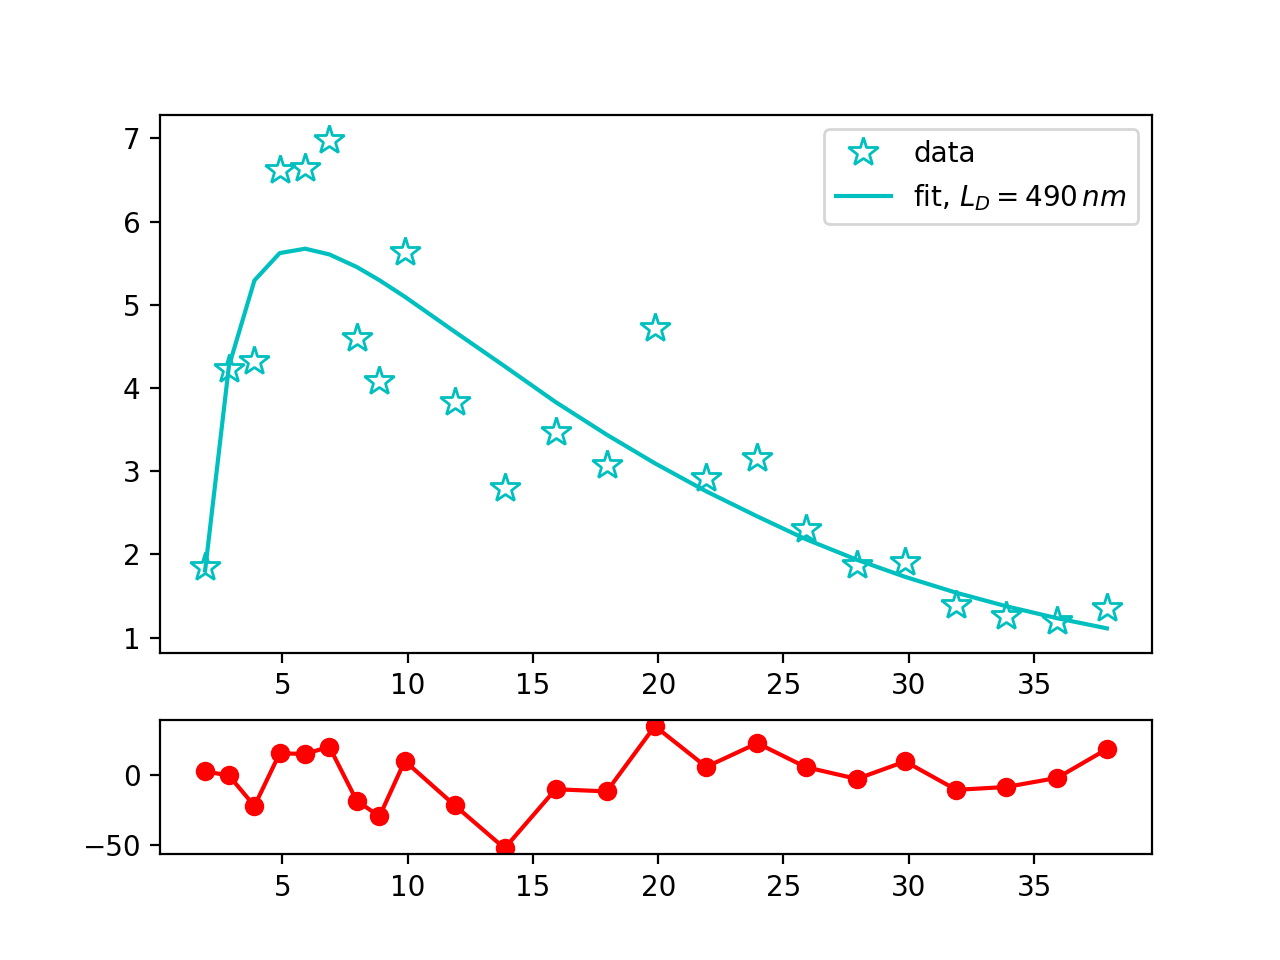

In [12]:
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4,1]})
gs = axs[0].get_gridspec()
#grid = gs.GridSpec(2,1 , height_ratios=[2,1])

axs[0].plot(E, I_data, 'c*', label = r'data', ms = 11, mfc='none')
axs[0].plot(E, I_fit,  'c-', label = r'fit, $L_D = %.0f \,nm$'%params[2])
axs[0].legend()

axs[1].plot(E, (I_data - I_fit)/I_data*100, '-ro',label = 'Error %')

### Alpha

In [13]:
path = 'data/alpha.csv'
E, I_data, I_fit, params = fit_data(path = path, tm = 40, W = 500)
data.append([E, I_data, I_fit, params, path])

Metal thickness : 38.64 nm
 SCR width : 519.92 nm
 Diffusion length : 151.65 ± 23.05 nm
 η/Ei :2.77 ± 7.48 eV-1
-----------------------------------------
Elapsed time: 16.57 s


<IPython.core.display.Javascript object>


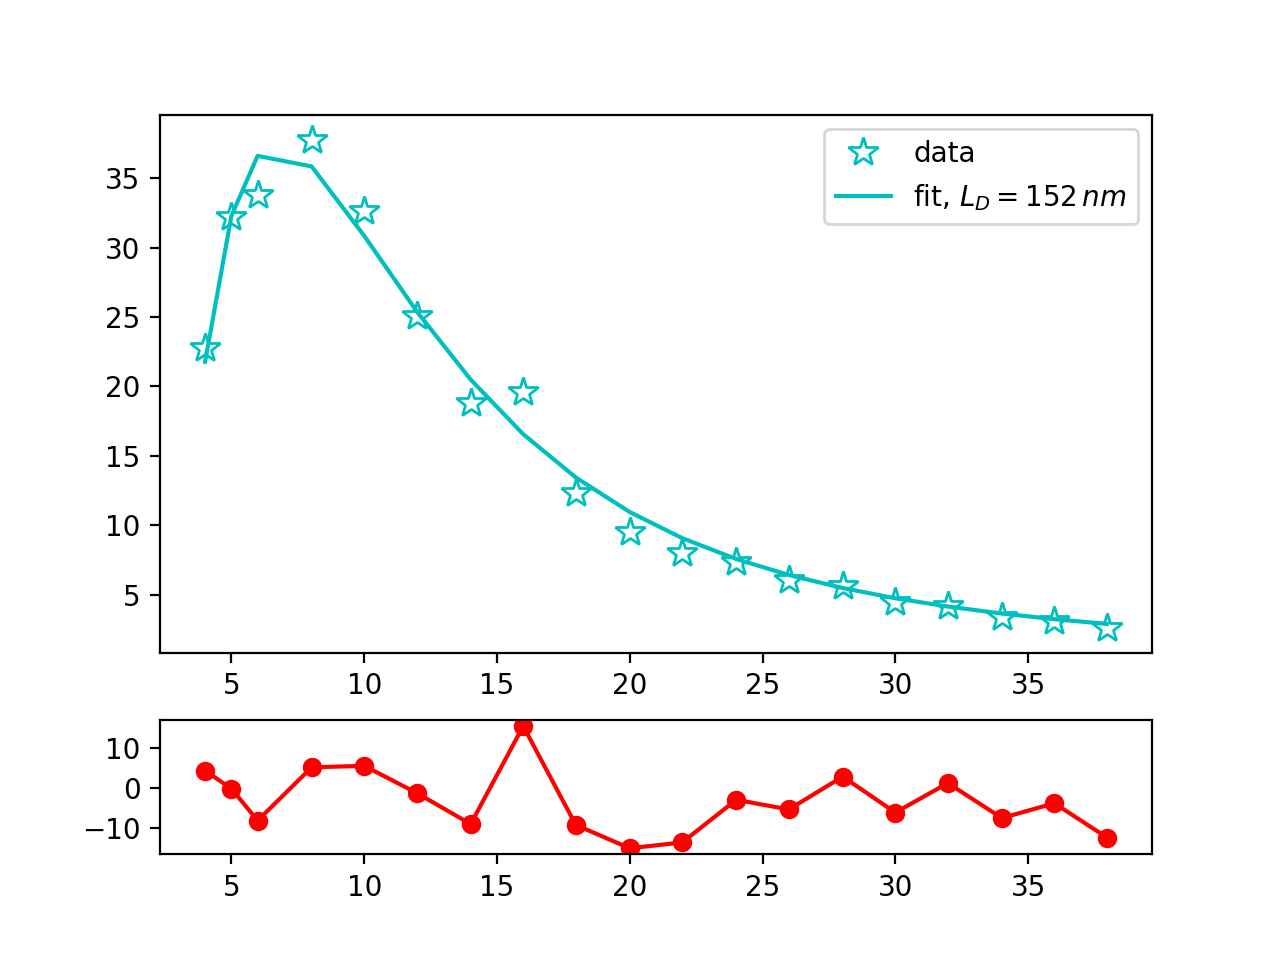

In [14]:
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4,1]})
gs = axs[0].get_gridspec()
#grid = gs.GridSpec(2,1 , height_ratios=[2,1])

axs[0].plot(E, I_data, 'c*', label = r'data', ms = 11, mfc='none')
axs[0].plot(E, I_fit,  'c-', label = r'fit, $L_D = %.0f \,nm$'%params[2])
axs[0].legend()

axs[1].plot(E, (I_data - I_fit)/I_data*100, '-ro',label = 'Error %')

### Total

<IPython.core.display.Javascript object>


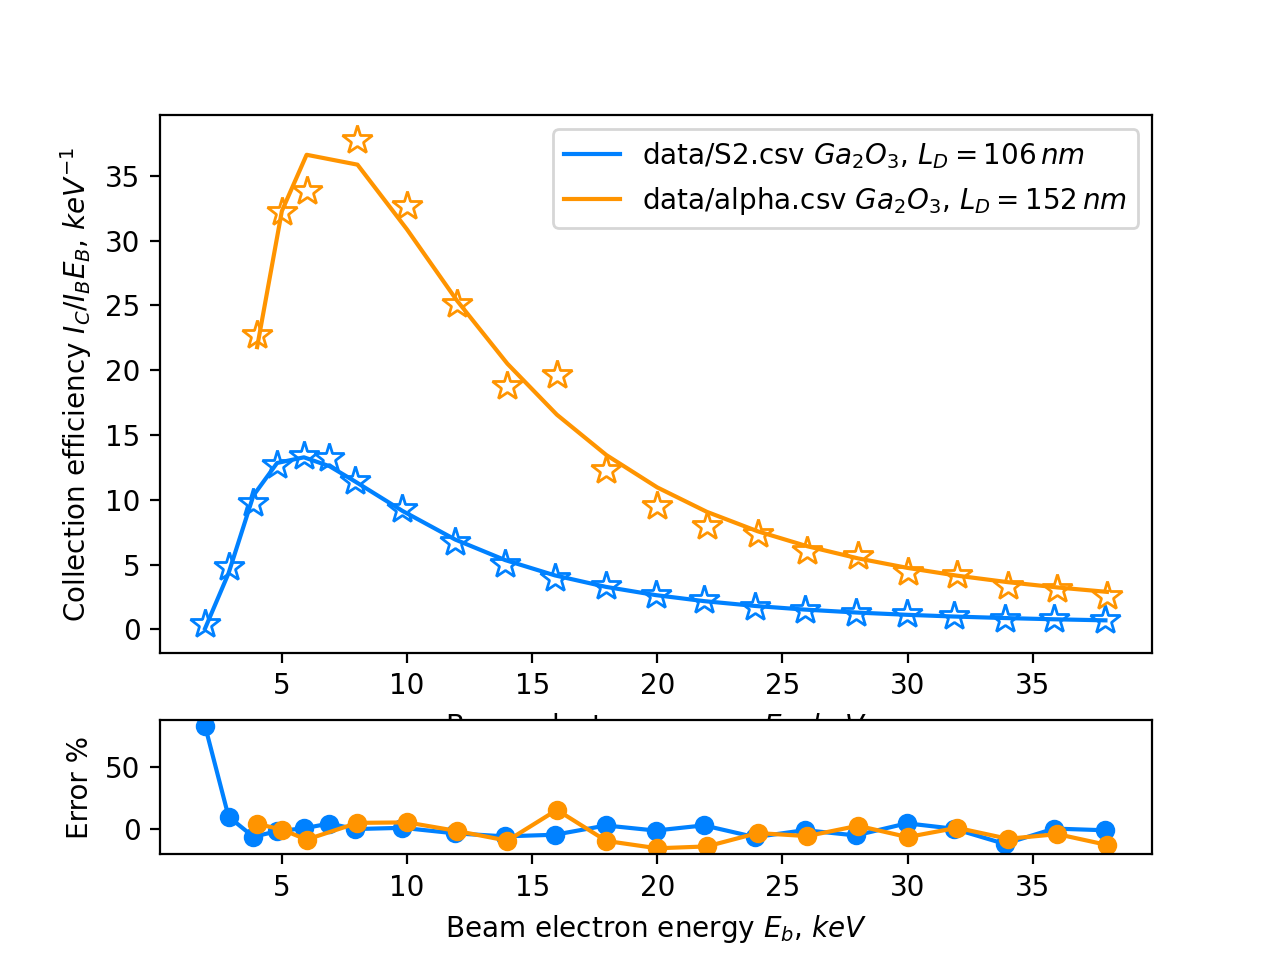

In [15]:
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4,1]})
gs = axs[0].get_gridspec()
#grid = gs.GridSpec(2,1 , height_ratios=[2,1])

axs[0].set_xlabel(r'Beam electron energy $E_b$, $keV$')
axs[1].set_xlabel(r'Beam electron energy $E_b$, $keV$')
axs[0].set_ylabel(r'Collection efficiency $I_C / I_B E_B$, ${keV}^{-1}$')
axs[1].set_ylabel(r'Error %')

c  = cm.jet(np.linspace(0, 1, len(data)))
p = [2, 4]
for i in p:
    E, I_data, I_fit, params, path = data[i]
    axs[0].plot(E, I_data, '*', c = c[i-1], ms = 11, mfc='none')
    axs[0].plot(E, I_fit,  '-', c = c[i-1], label = path + r' $Ga_2 O_3$' + r', $L_D = %.0f \,nm$'%params[2])
    
    axs[1].plot(E, (I_data - I_fit)/I_data*100, '-o' , c = c[i-1])
axs[0].legend()
#plt.savefig('diff_length.svg')